<a href="https://colab.research.google.com/github/abishekP101/Pytorch/blob/main/Sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abishek11prasad
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 797MB/s]

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
data_df = pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json' , lines = True)
data_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(columns=['article_link'] , inplace=True)
data_df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
data_df.shape

(26708, 2)

In [ ]:
X_train ,X_test , y_train ,y_test = train_test_split(data_df['headline'] , data_df['is_sarcastic'] , test_size=0.2 , random_state=42)


In [ ]:
X_val , X_test , y_val , y_test = train_test_split(X_test , y_test , test_size=0.5 , random_state=42)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
class dataset(Dataset):
  def __init__(self , X , y):
    self.X = [tokenizer(x ,
                        max_length = 100,
                        truncation=True ,
                        padding= "max_length" ,
                        return_tensors = 'pt').to(device)
                        for x in X
              ]
    self.y = torch.Tensor(y.values).to(device, dtype= torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self , idx):
    return self.X[idx] , self.y[idx]

training_data = dataset(X_train , y_train)
testing_data = dataset(X_test , y_test)
validation_data = dataset(X_val , y_val)

In [ ]:
batch_size = 32
epochs = 10
learning_rate = 1e-4

In [ ]:
train_loader = DataLoader(training_data , batch_size=32 , shuffle=True)
test_loader = DataLoader(testing_data , batch_size=32 , shuffle=True)
val_loader = DataLoader(validation_data , batch_size=32 , shuffle=True)

In [ ]:
class MyModel(nn.Module):
  def __init__(self , bert):
    super(MyModel , self).__init__()

    self.bert = bert
    self.dropout = nn.Dropout(0.25)
    self.linear1 = nn.Linear(768 , 384)
    self.linear2 = nn.Linear(384 , 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self , input_ids , attention_mask):
    pooled_out = self.bert(input_ids , attention_mask = attention_mask, return_dict=False)[0][: , 0]
    output = self.linear1(pooled_out)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)
    return output

In [ ]:
for param in bert_model.parameters():
  param.requires_grad = False
model = MyModel(bert_model).to(device)


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters() , lr=learning_rate)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(epochs):
  model.train()
  total_loss_train = 0
  total_acc_train = 0
  total_loss_val = 0
  total_acc_val = 0
  for indx , data in enumerate(train_loader):
    inputs , labels = data
    inputs.to(device)
    labels.to(device)

    prediction = model(inputs['input_ids'].squeeze(1) , inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss = criterion(prediction , labels)
    total_loss_train += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


  with torch.no_grad():
    model.eval()
    for indx , data in enumerate(val_loader):
      inputs , labels = data
      inputs.to(device)
      labels.to(device)

      prediction = model(inputs['input_ids'].squeeze(1) , inputs['attention_mask'].squeeze(1)).squeeze(1)
      batch_loss = criterion(prediction , labels)
      total_loss_val += batch_loss.item()

      acc = (prediction.round() == labels).sum().item()
      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train / len(train_loader) ,4))
  total_loss_validation_plot.append(round(total_loss_val / len(val_loader) , 4))
  total_acc_train_plot.append(round((total_acc_train /training_data.__len__())*100, 4))
  total_acc_validation_plot.append(round((total_acc_val / validation_data.__len__())*100 , 4))

  print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss_train_plot[-1]}, Train Acc: {total_acc_train_plot[-1]}%, Val Loss: {total_loss_validation_plot[-1]}, Val Acc: {total_acc_validation_plot[-1]}%")

Epoch 1/10, Train Loss: 0.4698, Train Acc: 78.7185%, Val Loss: 0.3841, Val Acc: 83.4893%
Epoch 2/10, Train Loss: 0.3994, Train Acc: 82.6313%, Val Loss: 0.3546, Val Acc: 84.6874%
Epoch 3/10, Train Loss: 0.3805, Train Acc: 83.4644%, Val Loss: 0.3432, Val Acc: 85.2864%
Epoch 4/10, Train Loss: 0.382, Train Acc: 83.4223%, Val Loss: 0.3363, Val Acc: 85.5485%
Epoch 5/10, Train Loss: 0.3766, Train Acc: 83.324%, Val Loss: 0.3303, Val Acc: 86.2598%
Epoch 6/10, Train Loss: 0.3695, Train Acc: 84.0728%, Val Loss: 0.3325, Val Acc: 85.6982%
Epoch 7/10, Train Loss: 0.3745, Train Acc: 83.7171%, Val Loss: 0.3252, Val Acc: 86.5219%
Epoch 8/10, Train Loss: 0.3726, Train Acc: 84.0635%, Val Loss: 0.329, Val Acc: 86.0726%
Epoch 9/10, Train Loss: 0.3668, Train Acc: 84.1992%, Val Loss: 0.325, Val Acc: 86.1101%
Epoch 10/10, Train Loss: 0.3705, Train Acc: 84.0588%, Val Loss: 0.3257, Val Acc: 86.2224%


In [ ]:
model.eval()
total_loss_test = 0
total_acc_test = 0
with torch.no_grad():
  for indx , data in enumerate(test_loader):
    inputs , labels = data
    inputs.to(device)
    labels.to(device)

    prediction = model(inputs['input_ids'].squeeze(1) , inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss = criterion(prediction , labels)
    total_loss_test += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()
    total_acc_test += acc

print(f"Test Loss: {round(total_loss_test / len(test_loader) , 4)}, Test Acc: {round((total_acc_test / testing_data.__len__())*100 , 4)}%")

Test Loss: 0.3348, Test Acc: 84.9869%


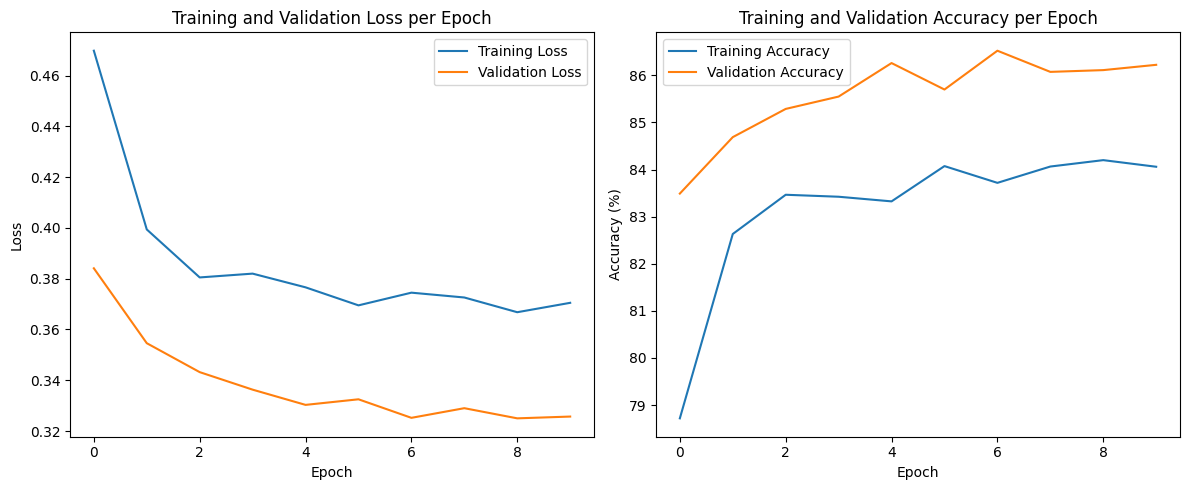

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(total_loss_train_plot, label='Training Loss')
plt.plot(total_loss_validation_plot, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(total_acc_train_plot, label='Training Accuracy')
plt.plot(total_acc_validation_plot, label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()